In [1]:
import numpy as np # numpy : 행렬이나 일반적으로 대규모 다차원 배열을 쉽게 처리

#실행 시마다 같은 결과값 도출을 위한 시드 설정
np.random.seed(7) # seed 설정 # seed : 특정 시작 숫자

# 훈련데이터 세트 분할
from sklearn.model_selection import train_test_split
# sklearn.model_selection 모듈에서 train_test_split() 함수를 import
from sklearn.metrics import confusion_matrix # 혼동행렬을 위한 기능 불러옴
import itertools # 자신만의 반복자를 만드는 모듈

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
# one-hot encoding : 1차원 배열에 각각의 숫자일 확률을 기록 & 그 확률이 가장 높은 것을 정답으로 취급
from keras.models import Sequential # Sequential 모델 : 레이어를 선형으로 연결하여 구성
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop # RMSprop : 딥러닝 최적화 기법
from keras.preprocessing.image import ImageDataGenerator
# 실시간 데이터 증강을 사용해서 텐서 이미지 데이터 배치를 생성
from keras.callbacks import ReduceLROnPlateau # 콜백함수
# 학습률이 개선되지 않을 때, 학습률을 동적으로 조정하여 학습률을 개선하는 효과


#sns.set(style='white', context='notebook', palette='deep')

In [2]:
from __future__ import print_function
# __future__ : 파이썬2.x 에서 몇몇 기능들을 파이썬3.x 와 같이 사용 가능하게 만들어줌
import keras
from keras.datasets import mnist # mnist 데이터셋 호출
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# 데이터를 불러와서 각 변수에 저장
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train : 2828의 행렬을 2828 픽셀로 생각했을때, 숫자가 작을수록 해당 픽셀의 색이
#진한 검정색을 의미. (0에 가까울수록 검은색, 255에 가까울수록 하얀색)
#y_train : 정답(숫자)

# 60000개 데이터 배열에서 0번째 원소를 흑백으로 출력
#plt.imshow(x_train[0], cmap='Greys')
#plt.show()

# 0번째 원소의 모든 데이터를 출력
#for x in x_train[0]:
  #for i in x:
    #sys.stdout.write('%d ' % i)
  #sys.stdout.write('\n')

if K.image_data_format() == 'channels_first':
  # image_data_format이 ‘channels_first’인 경우 (샘플 수, 채널 수, 행, 열)로 이루어진 4D 텐서
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# 학습에 적합한 형태로 데이터 가공
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
# ((60000, 28, 28), (60000, ))
print(x_train.shape[0], 'train samples') # 학습셋 이미지 수
print(x_test.shape[0], 'test samples') # 테스트셋 이미지 수

# 클래스를 학습에 이용하기 위해 데이터 가공
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
# 딥러닝 모델 구조 설정
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

# (2개층, 128개의 뉴런 연결, 10개 클래스 출력 뉴런, 784개 픽셀 input 값, relu와 softmax 활성화 함수 이용)
model.add(Dense(128, input_dim = 784, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline
# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 딥러닝 구조 설정(loss 옵션을 다중 클래스에 적합한 categorical_crossentropy, 옵티마이저는 Adam 설정)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

# 학습 loss값, 정확도 출력
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 모델 저장
model.save('digit_model.h5')

Epoch 1/12
469/469 [==============================] - 171s 362ms/step - loss: 0.2342 - accuracy: 0.9287 - val_loss: 0.0546 - val_accuracy: 0.9827
Epoch 2/12
469/469 [==============================] - 170s 363ms/step - loss: 0.0803 - accuracy: 0.9761 - val_loss: 0.0368 - val_accuracy: 0.9880
Epoch 3/12
469/469 [==============================] - 173s 370ms/step - loss: 0.0607 - accuracy: 0.9814 - val_loss: 0.0324 - val_accuracy: 0.9893
Epoch 4/12
469/469 [==============================] - 167s 357ms/step - loss: 0.0476 - accuracy: 0.9856 - val_loss: 0.0311 - val_accuracy: 0.9907
Epoch 5/12
469/469 [==============================] - 171s 365ms/step - loss: 0.0433 - accuracy: 0.9869 - val_loss: 0.0308 - val_accuracy: 0.9909
Epoch 6/12
469/469 [==============================] - 167s 356ms/step - loss: 0.0373 - accuracy: 0.9882 - val_loss: 0.0290 - val_accuracy: 0.9909
Epoch 7/12
469/469 [==============================] - 174s 370ms/step - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.0277 -

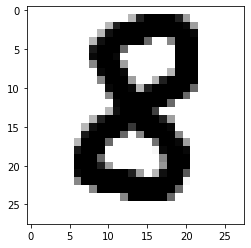

1/1 [==============================] - 0s 23ms/step
The Answer is  [8]


In [16]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('test8.png')
img_test = cv2.imread('test8.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()

img_test = cv2.resize(255-img_test, (28, 28))
test_num = img_test.flatten() / 255.0
test_num = test_num.reshape((-1, 28, 28, 1))

res = model.predict(test_num)
predicted = res.argmax(axis=-1)
print('The Answer is ', predicted)